# Deblur Immagini
Il problema di deblur consiste nella ricostruzione di un immagine a partire da un dato acquisito mediante il seguente modello:

\begin{align*}
    b = A x + \eta
\end{align*}

dove $b$ rappresenta l'immagine corrotta, $x$ l'immagine originale che vogliamo ricostruire, $A$ l'operatore che applica il blur Gaussiano ed $\eta$ il rumore additivo con distribuzione Gaussiana di  media $\mathbb{0}$ e deviazione standard $\sigma$.

## Funzioni di blur
Le seguenti funzioni servono per applicare il blur di tipo gaussiano ad un'immagine.



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, metrics
from scipy import signal
from numpy import fft

# Create a Gaussian kernel of size kernlen and standard deviation sigma
def gaussian_kernel(kernlen, sigma):
    x = np.linspace(- (kernlen // 2), kernlen // 2, kernlen)    
    # Unidimensional Gaussian kernel
    kern1d = np.exp(- 0.5 * (x**2 / sigma))
    # Bidimensional Gaussian kernel
    kern2d = np.outer(kern1d, kern1d)
    # Normalization
    return kern2d / kern2d.sum()

# Compute the FFT of the kernel 'K' of size 'd' padding with the zeros necessary
# to match the size of 'shape'
def psf_fft(K, d, shape):
    # Zero padding
    K_p = np.zeros(shape)
    K_p[:d, :d] = K

    # Shift
    p = d // 2
    K_pr = np.roll(np.roll(K_p, -p, 0), -p, 1)

    # Compute FFT
    K_otf = fft.fft2(K_pr)
    return K_otf

# Multiplication by A
def A(x, K):
  x = fft.fft2(x)
  return np.real(fft.ifft2(K * x))

# Multiplication by A transpose
def AT(x, K):
  x = fft.fft2(x)
  return np.real(fft.ifft2(np.conj(K) * x))

## Generazione dataset
Generare un set di 8 immagini 512$\times$512 in formato ${\tt png}$ in scala dei grigi che contengano tra i 2 ed i 6 oggetti geometrici, di colore uniforme, su sfondo nero. 


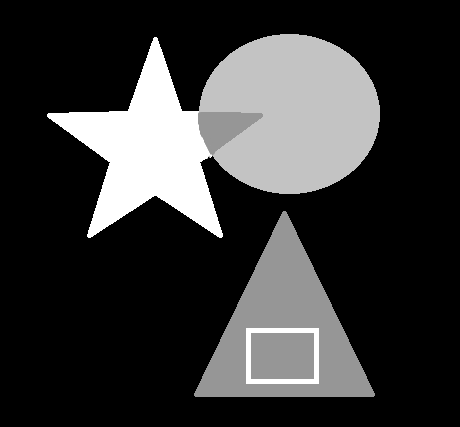


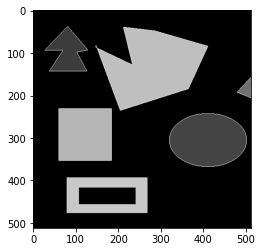

In [ ]:
from skimage.io import imread
from skimage import data
X = data.camera().astype(np.float64) / 255.0
m, n = X.shape
x = X.reshape(m*n)

Z = imread("./1.png", as_gray=True).astype(np.float64)
z = Z.reshape(m*n)
plt.imshow(Z, cmap="gray", vmin=0, vmax=1)

## 1) Generazione immagini corrotte
Degradare le immagini applicando, mediante le funzioni riportate nella cella precedente,  l'operatore di blur con parametri

+ $\sigma=0.5$ dimensione $5\times 5$
+ $\sigma=1$ dimensione $7\times 7$
+ $\sigma=1.3$ dimensione $9\times 9$

ed aggiungendo rumore gaussiano con deviazione standard $(0,0.05]$

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


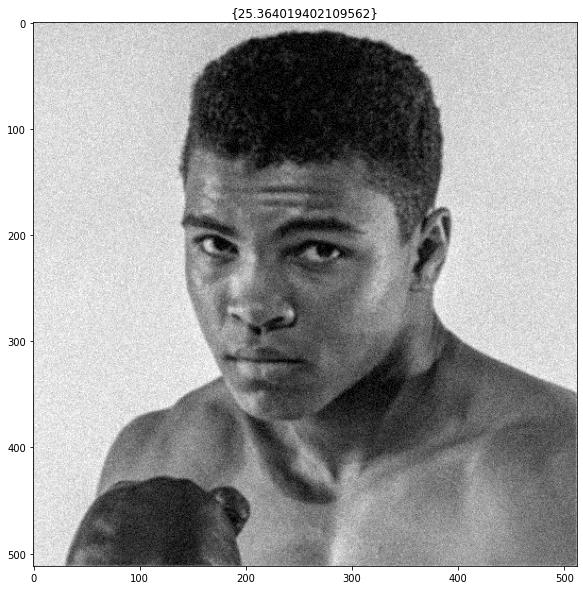

In [ ]:
K = psf_fft(gaussian_kernel(7, 1), 7, X.shape)
std_dev = 0.05
noise = np.random.normal(size=X.shape)*std_dev

X_blur = A(X, K)
x_blur = X_blur.reshape(m*n)
B = X_blur + noise
b = B.reshape(m*n)
PSNR = metrics.peak_signal_noise_ratio(X, B)

Z_blur = A(Z, K)
z_blur = Z_blur.reshape(m*n)
ZB = Z_blur + noise
zB = ZB.reshape(m*n)
PSNR = metrics.peak_signal_noise_ratio(Z, ZB)

plt.figure(figsize=(30,10))
plt.title({PSNR})
plt.subplot(111).imshow(ZB, cmap='gray', vmin=0, vmax=1)


## 2) Soluzione naive

Una possibile ricostruzione dell'immagine originale $x$ partendo dall'immagine corrotta $b$ è la soluzione naive data dal minimo del seguente problema di ottimizzazione:
\begin{align}
  x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2
\end{align}

La funzione $f$ da minimizzare è data dalla formula
  $f(x) = \frac{1}{2} ||Ax - b||_2^2 $, il cui gradiente $\nabla f$ è dato da
$\nabla f(x) = A^TAx - A^Tb  $.

Utilizzando il metodo del gradiente coniugato implementato dalla funzione `minimize` calcolare la soluzione naive. 

         Current function value: 245.248689
         Iterations: 3
         Function evaluations: 10
         Gradient evaluations: 10


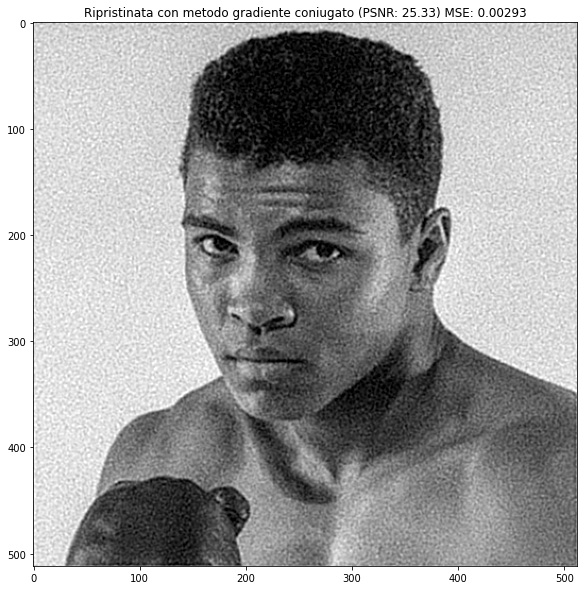

In [ ]:
from scipy.optimize import minimize
def f(x, B, labda = 0):
  X = x.reshape(m,n)
  res = 0.5*(np.linalg.norm(A(X, K)-B))**2 + 0.5*labda*(np.linalg.norm(X))**2
  return np.sum(res)
def df(x, B, labda=0):
  X = x.reshape(m,n)
  res = AT(A(X, K)-B, K) + labda*X
  RES = np.reshape(res, m*n)
  return RES

alfabeto = ['CB', 'DB', 'EB', 'IB', ZB] #altrimenti se virgolettato dà errore

func = lambda x: f(x, alfabeto[4]) #o exec 
grad_func = lambda x: df(x, alfabeto[4])
res = minimize(func, np.zeros(b.shape), method="CG", jac=grad_func, options={'disp': True, 'maxiter':3})
RES = res.x.reshape(m,n)

PSNR = metrics.peak_signal_noise_ratio(Z, RES) #alfabeto[4] solo lettere
MSE = metrics.mean_squared_error(Z, RES)


plt.figure(figsize=(30,10))
plt.title(f'Ripristinata con metodo gradiente coniugato (PSNR: {PSNR:.2f}) MSE: {MSE:.5f}')

plt.imshow(RES, cmap="gray", vmin=0, vmax=1)
#i+=1


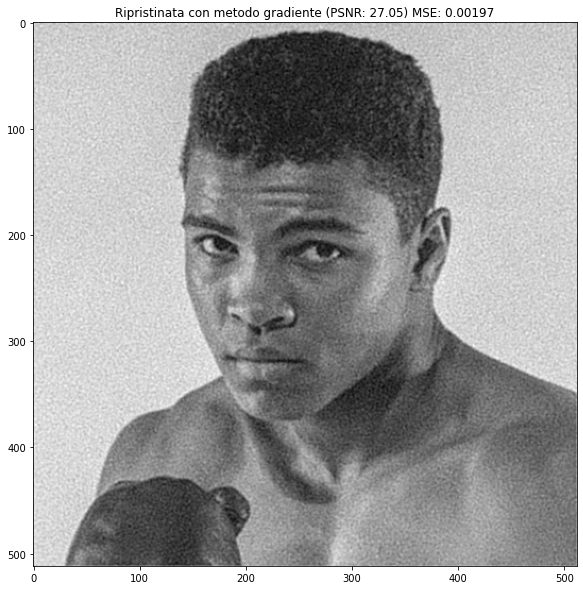

In [ ]:
def next_step(x, grad, B, labda = 0): # backtracking procedure for the choice of the steplength
  alpha=1.1
  c1 = 0.25
  p=-grad
  j=0
  jmax=10
  #condizioni che servono per soddisfare dei criteri di convergenza - condizioni di Wolfe
  while ((f(x + alpha*p, B, labda) > f(x, B, labda)+c1*alpha*grad.T@p) and j<jmax):
    alpha = alpha*0.5
    j+=1
  return alpha

def gradient_minimize(B, labda= 0, maxit=6, abstop = 1.e-6):
  x_last =np.zeros(m*n)
  k = 0
  while (np.linalg.norm(df(x_last, B, labda))>abstop and k < maxit):
    k=k+1
    grad = df(x_last, B, labda)
    step = next_step(x_last, grad, B, labda)
    x_last=x_last-step*grad
  return x_last
z_naive = gradient_minimize(ZB)
PSNR = metrics.peak_signal_noise_ratio(Z, z_naive.reshape(m,n))#cambiare anche qui ogni volta nome immagine originale
MSE = metrics.mean_squared_error(Z, z_naive.reshape(m,n))
plt.figure(figsize=(30,10))
plt.title(f'Ripristinata con metodo gradiente (PSNR: {PSNR:.2f}) MSE: {MSE:.5f}')
plt.imshow(z_naive.reshape(m,n), cmap="gray")

## 3) Regolarizzazione
Per ridurre gli effetti del rumore nella ricostruzione è necessario introdurre un termine di regolarizzazione di Tikhonov. Si considera quindi il seguente problema di ottimizzazione.
\begin{align*}
  x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 + \frac{\lambda}{2} ||x||_2^2
\end{align*}

La funzione $f$ da minimizzare diventa
$f(x) = \frac{1}{2} ||Ax - b||_2^2 + \frac{\lambda}{2} ||x||_2^2$
il cui gradiente $\nabla f$ è dato da
$\nabla f(x) = A^TAx - A^Tb + λx$.

Utilizzando il metodo del gradiente coniugato implementato dalla funzione `minimize` ed il metodo del gradiente implementato a lezione, calcolare la soluzione del precendente problema di minimo regolarizzato per differenti valori di $\lambda$. 

         Current function value: 245.773646
         Iterations: 3
         Function evaluations: 10
         Gradient evaluations: 10
lambda: 1e-05 PSNR: 25.33
         Current function value: 352.669933
         Iterations: 3
         Function evaluations: 10
         Gradient evaluations: 10
lambda: 0.0020506122448979594 PSNR: 25.40
         Current function value: 459.116389
         Iterations: 3
         Function evaluations: 10
         Gradient evaluations: 10
lambda: 0.004091224489795918 PSNR: 25.48
         Current function value: 565.116198
         Iterations: 3
         Function evaluations: 10
         Gradient evaluations: 10
lambda: 0.006131836734693878 PSNR: 25.54
         Current function value: 670.672502
         Iterations: 3
         Function evaluations: 10
         Gradient evaluations: 10
lambda: 0.008172448979591837 PSNR: 25.60
         Current function value: 775.788400
         Iterations: 3
         Function evaluations: 10
         Gradient evaluations: 10

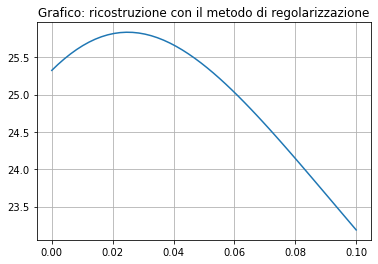

In [ ]:
labda = np.linspace(1e-5, 1e-1, 50)

lista_lambda = []
lista_psnr = []

for i in range(50): 
  func = lambda x: f(x, ZB, labda[i])
  grad_func = lambda x: df(x, ZB, labda[i])
  res = minimize(func, np.zeros(b.shape), method="CG", jac=grad_func, options={'disp': True, 'maxiter':3})
  RES = res.x.reshape(m,n)

  PSNR = metrics.peak_signal_noise_ratio(Z, RES)
  lista_psnr.append(PSNR)
  lista_lambda.append(labda[i])
  print(f'lambda: {labda[i]} PSNR: {PSNR:.2f}')

plt.plot(lista_lambda, lista_psnr)
plt.title('Grafico: ricostruzione con il metodo di regolarizzazione')
plt.grid(True)
plt.show()




lambda: 1e-05 PSNR: 27.04524323276651
lambda: 0.0020506122448979594 PSNR: 27.07710836564756
lambda: 0.004091224489795918 PSNR: 27.101426126592134
lambda: 0.006131836734693878 PSNR: 27.11816329074685
lambda: 0.008172448979591837 PSNR: 27.127325834010346
lambda: 0.010213061224489797 PSNR: 27.128958830277284
lambda: 0.012253673469387756 PSNR: 27.123145675962874
lambda: 0.014294285714285714 PSNR: 27.110006669653917
lambda: 0.016334897959183674 PSNR: 27.089696997169973
lambda: 0.018375510204081635 PSNR: 27.062404191740438
lambda: 0.020416122448979595 PSNR: 27.028345154367948
lambda: 0.02245673469387755 PSNR: 26.98776283006631
lambda: 0.024497346938775512 PSNR: 26.940922641234906
lambda: 0.026537959183673472 PSNR: 26.88810878005014
lambda: 0.02857857142857143 PSNR: 26.82962045784717
lambda: 0.03061918367346939 PSNR: 26.765768201728264
lambda: 0.03265979591836735 PSNR: 26.69687027793694
lambda: 0.03470040816326531 PSNR: 26.62324930883056
lambda: 0.03674102040816327 PSNR: 26.545229136507153
la

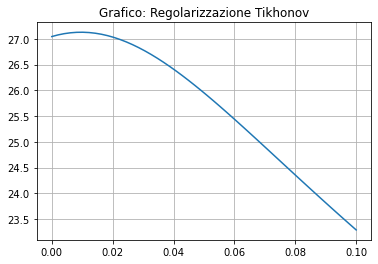

In [ ]:
labda = list(np.linspace(1e-5, 1e-1, 50))
lista_lambda2 = []
lista_psnr2 = []
for i in range(50):
  z_tikhonov = gradient_minimize(ZB, labda[i])
  PSNR = metrics.peak_signal_noise_ratio(Z, z_tikhonov.reshape(m,n))
  lista_psnr2.append(PSNR)
  lista_lambda2.append(labda[i])
  print(f'lambda: {labda[i]} PSNR: {PSNR}')

plt.plot(lista_lambda2, lista_psnr2)
plt.title('Grafico: Regolarizzazione Tikhonov')
plt.grid(True)
plt.show()




## 4) Variazione Totale (Facoltativo) 

Un altra funzione adatta come termine di regolarizzazione è la Variazione Totale. Data $u$ immagine di dimensioni $m\times n$ la variazione totale $TV$ di $u$ è definit come:
\begin{align*}
  TV(u) = \sum_i^n{\sum_j^m{\sqrt{||\nabla u(i, j)||_2^2 + \epsilon^2}}}
\end{align*}
Per calcolare il gradiente dell'immagine $\nabla u$ usiamo la funzione `np.gradient` che approssima la derivata per ogni pixel calcolando la differenza tra pixel adiacenti. I risultati sono due immagini della stessa dimensione dell'immagine in input, una che rappresenta il valore della derivata orizzontale `dx` e l'altra della derivata verticale `dy`. Il gradiente dell'immagine nel punto $(i, j)$ è quindi un vettore di due componenti, uno orizzontale contenuto in `dx` e uno verticale in `dy`.

Come nei casi precedenti il problema di minimo che si va a risolvere è il seguente:
\begin{align*}
  x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 + \lambda TV(u)
\end{align*}
il cui gradiente $\nabla f$ è dato da
\begin{align*}
\nabla f(x) = (A^TAx - A^Tb)  + \lambda \nabla TV(x)
\end{align*}

Utilizzando il metodo del gradiente implementato a lezione, calcolare la soluzione del precendente problema di minimo regolarizzato per differenti valori di $\lambda$. 


---
Per risolvere il problema di minimo è necessario anche calcolare il gradiente della variazione totale che è definito nel modo seguente
\begin{align*}
  \nabla TV(u) = -div\left(\frac{\nabla u}{\sqrt{||\nabla u||_2^2 + \epsilon^2}}\right)
\end{align*}

\begin{align*}
  div(F) = \frac{\partial F_x}{\partial x} + \frac{\partial F_y}{\partial y}
\end{align*}

$div(F)$ è la divergenza del campo vettoriale $F$, nel nostro caso $F$ ha due componenti dati dal gradiente dell'immagine $\nabla u$ scalato per il valore $ \frac{1}{\sqrt{||\nabla u||_2^2 + \epsilon^2}}$. Per calcolare la divergenza bisogna calcolare la derivata orizzontale $\frac{\partial F_x}{\partial x}$ della componente $x$ di $F$ e sommarla alla derivata verticale $\frac{\partial F_y}{\partial y}$ della componente $y$ di $F$. Per specificare in quale direzione calcolare la derivata con la funzione `np.gradient` utilizziamo il parametro `axis = 0` per l'orizzontale e `axis = 1` per la verticale.

In [ ]:
eps = 1e-2

# Variazione totale
def totvar(x):
  # Calcola il gradiente di x
  dx, dy = np.gradient(x)
  n2 = np.square(dx) + np.square(dy)

  # Calcola la variazione totale di x
  tv = np.sqrt(n2 + eps**2).sum()
  return tv

# Gradiente della variazione totale
def grad_totvar(x):
  # Calcola il numeratore della frazione
  dx, dy = np.gradient(x)

  # Calcola il denominatore della frazione
  n2 = np.square(dx) + np.square(dy)
  den = np.sqrt(n2 + eps**2)

  # Calcola le due componenti di F dividendo il gradiente per il denominatore
  Fx = dx / den
  Fy = dy / den

  # Calcola la derivata orizzontale di Fx 
  dFdx = np.gradient(Fx, axis=0)
  
  # Calcola la derivata verticale di Fy
  dFdy = np.gradient(Fy, axis=1)

  # Calcola la divergenza 
  div = (dFdx + dFdy)

  # Restituisci il valore del gradiente della variazione totale
  return -div

sto analizzando immagine B. lambda: 1e-07 PSNR: 26.29 MSE: 0.002350638763939042 Errore relativo: 0.08320152507787856
sto analizzando immagine B. lambda: 0.010204179591836735 PSNR: 28.18 MSE: 0.0015188114564090812 Errore relativo: 0.0668790772309489
sto analizzando immagine B. lambda: 0.02040825918367347 PSNR: 28.39 MSE: 0.0014478504098685999 Errore relativo: 0.06529804619254041
sto analizzando immagine B. lambda: 0.030612338775510204 PSNR: 28.13 MSE: 0.001539687235804918 Errore relativo: 0.06733712884795665
sto analizzando immagine B. lambda: 0.040816418367346945 PSNR: 27.90 MSE: 0.0016221154880426277 Errore relativo: 0.06911610019928
sto analizzando immagine B. lambda: 0.05102049795918368 PSNR: 27.69 MSE: 0.0017008182139804703 Errore relativo: 0.07077294846772363
sto analizzando immagine B. lambda: 0.06122457755102041 PSNR: 27.36 MSE: 0.0018370442690347488 Errore relativo: 0.07355262065443405
sto analizzando immagine B. lambda: 0.07142865714285715 PSNR: 27.04 MSE: 0.001978585445317114

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: UserWarning: Legend does not support 'P' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: UserWarning: Legend does not support 'S' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: UserWarning: Legend does not support 'N' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


<Figure size 432x288 with 0 Axes>

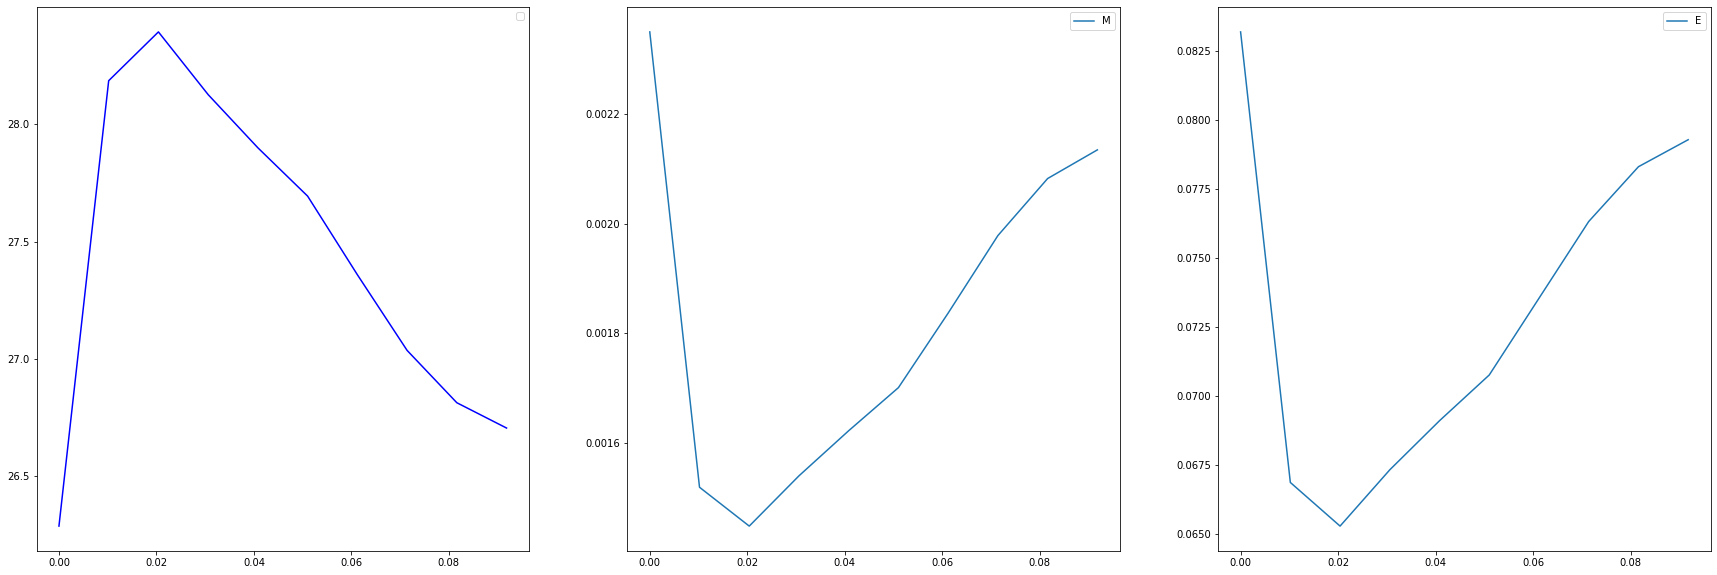

<Figure size 432x288 with 0 Axes>

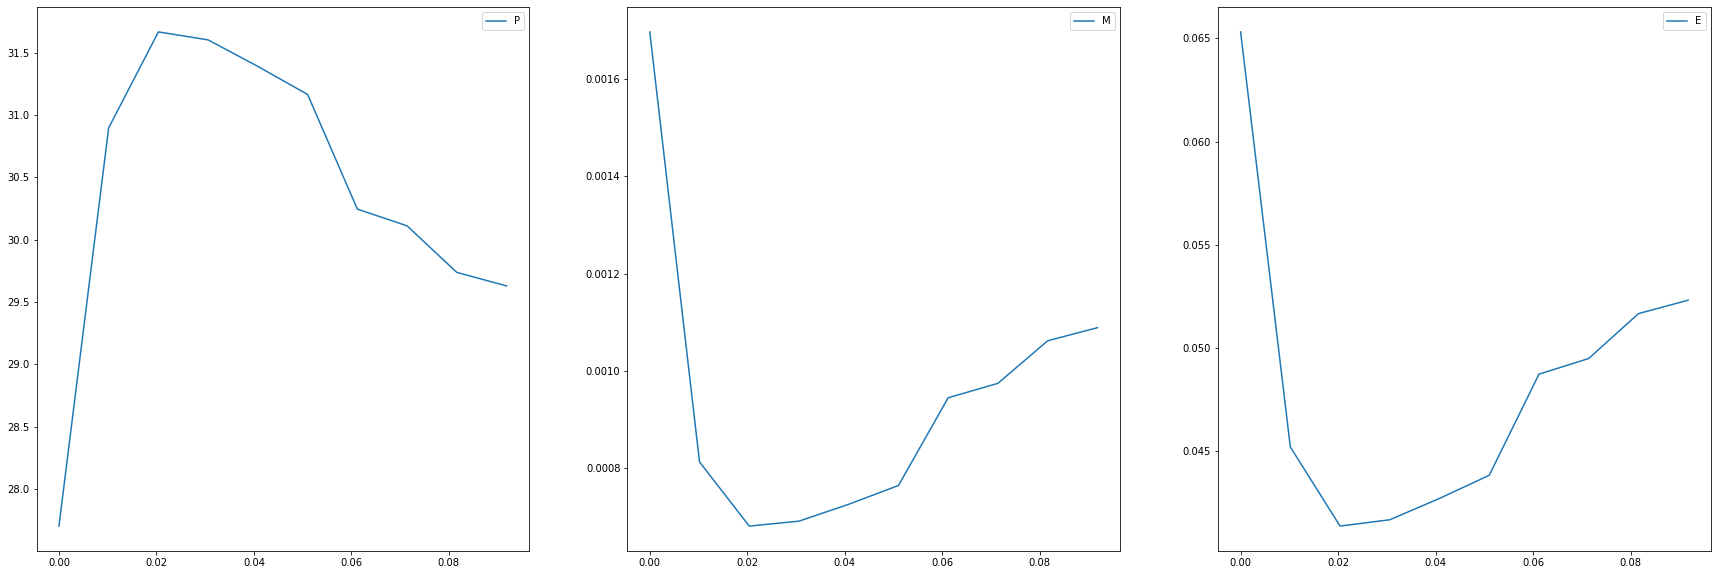

In [ ]:
def f_tv(x, B, labda):
  X = x.reshape(m,n)
  res = 0.5*(np.linalg.norm(A(X, K)-B))**2 + labda*totvar(X)
  return np.sum(res)
def df_tv(x, B, labda):
  X = x.reshape(m,n)
  res = AT(A(X, K)-B, K) + labda*grad_totvar(X)
  RES = np.reshape(res, m*n)
  return RES
def next_step_tv(x,grad, B, labda): # backtracking procedure for the choice of the steplength
  alpha=1.1
  c1 = 0.25
  p=-grad
  j=0
  jmax=10
  #condizioni che servono per soddisfare dei criteri di convergenza - condizioni di Wolfe
  while ((f_tv(x + alpha*p, B, labda) > f_tv(x, B, labda)+c1*alpha*grad.T@p) and j<jmax):
    alpha= alpha*0.5
    j+=1
  return alpha
def gradient_minimize_tv(B, labda, maxit=5, abstop = 1.e-6):
  x_last = np.zeros(m*n)
  k = 0
  while (np.linalg.norm(df_tv(x_last, B, labda))>abstop and k < maxit):
    k=k+1
    grad = df_tv(x_last, B, labda)
    step = next_step_tv(x_last, grad, B, labda)
    x_last=x_last-step*grad
  return x_last


###################NON TOCCARE LE FUNZIONI SOPRA PERCHE' SONO CORRETTE######################


labda = list(np.linspace(0.0000001, 0.5, 50))
immaginiCorrotteLista = [B, ZB] #le immagini corrotte sono quelle del tipo X_blur + noise
immaginiPuliteLista = [X, Z] #sono le immagini pulite

#per ogni immagine
listaPSNR_B = []
listaMSE_B = []
listaERRREL_B = []

listaPSNR_ZB = []
listaMSE_ZB = []
listaERRREL_ZB = []

for j in range(len(immaginiCorrotteLista)):
  for i in range(10): #ho messo 10 per fare prima. mettere 50 (numero di lambda) durante relazione
    ricostruzione_tv = gradient_minimize_tv(immaginiCorrotteLista[j], labda[i])
    RICOSTRUZIONE_tv = ricostruzione_tv.reshape(m,n) #per convenzione abbiamo usato che le variabili in minuscolo sono vettori di dimensione m*n mentre le variabili in MAIUSCOLO sono MATRICI di dimensione (m,n)
    PSNR = metrics.peak_signal_noise_ratio(immaginiPuliteLista[j], RICOSTRUZIONE_tv) #primo argomento immagine pulita, secondo argomento l'immagine ricostruita col metodo che stiamo utilizzando attualmente
    MSE = metrics.mean_squared_error(immaginiPuliteLista[j], RICOSTRUZIONE_tv)
    erroreRelativo = np.linalg.norm(RICOSTRUZIONE_tv - immaginiPuliteLista[j], 'fro')/np.linalg.norm(immaginiPuliteLista[j], 'fro') #errore relativo in norma di frobenius. Gli altri progetto mi ricordo che utilizzavano questa

    #per ogni immagine
    if (immaginiCorrotteLista[j] is B):
      listaPSNR_B.append(PSNR)
      listaMSE_B.append(MSE)
      listaERRREL_B.append(erroreRelativo)
      print(f'sto analizzando immagine B. lambda: {labda[i]} PSNR: {PSNR:.2f} MSE: {MSE} Errore relativo: {erroreRelativo}')
    
    #per tutte le immagini. L'importante non è divertirsi ma il meschino voto/risultato
    elif immaginiCorrotteLista[j] is ZB:
      listaPSNR_ZB.append(PSNR)
      listaMSE_ZB.append(MSE)
      listaERRREL_ZB.append(erroreRelativo)
      print(f'sto analizzando immagine ZB. lambda: {labda[i]} PSNR: {PSNR:.2f} MSE: {MSE} Errore relativo: {erroreRelativo}')



#dopo che ho ottenuto le mie liste sono pronto a plottare (sempre per ogni immagine)
for j in range(len(immaginiCorrotteLista)):
  #per ogni immagine
  if (immaginiCorrotteLista[j] is B): 
    plt.suptitle("STO ANALIZZANDO RICOSTRUZIONE RIGUARDO X (B ERA LA SUA CORROTTA")
    plt.figure(figsize=(30,10))
    plt.subplot(1,3,1)
    plt.plot(labda[:10], listaPSNR_B, 'r', color="blue") #r di retta, togliere il [:10] durante relazione messo per fare prima test
    plt.legend("PSNR", "MSE") #accetta al massimo due
    plt.subplot(1,3,2)
    plt.plot(labda[:10], listaMSE_B) #togliere il [:10] durante relazione messo per fare prima test
    plt.legend("MSE")
    plt.subplot(1,3,3)
    plt.plot(labda[:10], listaERRREL_B) #togliere il [:10] durante relazione messo per fare prima test
    plt.legend("ERRORE RELATIVO")
    plt.show()
  
  elif immaginiCorrotteLista[j] is ZB:
    plt.suptitle("STO ANALIZZANDO RICOSTRUZIONE RIGUARDO Z (ZB ERA LA SUA CORROTTA")
    plt.figure(figsize=(30,10))
    plt.subplot(1,3,1)
    plt.plot(labda[:10], listaPSNR_ZB) #togliere il [:10] durante relazione messo per fare prima test
    plt.legend("PSNR")
    plt.subplot(1,3,2)
    plt.plot(labda[:10], listaMSE_ZB) #togliere il [:10] durante relazione messo per fare prima test
    plt.legend("MSE")
    plt.subplot(1,3,3)
    plt.plot(labda[:10], listaERRREL_ZB) #togliere il [:10] durante relazione messo per fare prima test
    plt.legend("ERRORE RELATIVO")
    plt.show()



# Relazione

1.   Riportare e commentare i risultati ottenuti nei punti 2. 3. (e 4.) su un immagine del set creato e su altre due immagini in bianco e nero  (fotografiche/mediche/astronomiche)
2.   Riportare delle tabelle con le misure di PSNR e MSE ottenute al variare dei parametri (dimensione kernel, valore di sigma, la deviazione standard del rumore, il parametro di regolarizzazione). 
3. Calcolare sull’intero set di immagini medie e deviazione standard delle metriche per alcuni valori fissati dei parametri.  
4. Analizzare su 2 esecuzioni le proprietà dei metodi numerici utilizzati (gradiente coniugato e gradiente) in termini di numero di iterazioni, andamento dell’errore, della funzione obiettivo, norma del gradiente. 

